In [1]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = (df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

In [3]:
def load_csv(number):
    path = r"C:\Users\ohad1\OneDrive\שולחן העבודה\לימודים\שנה ב\שנה ב סמסטר ב\רשתות תקשורת\מטלות\מטלת גמר\resources\CLEAN"
    if number == '1':
        path = path + "/whatsappMessagesCSVClean.csv"
        print("---------Messages----------")
    elif number == '2':
        path = path + "/whatsappImagesCSVClean.csv"
        print("---------Images----------")
    elif number == '3':
        path = path + "/whatsappAudioCSVClean.csv"
        print("---------Audio----------")
    elif number == '4':
        path = path + "/whatsappVideosCSVClean.csv"
        print("---------Videos and Files----------")

    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df

In [4]:
def load_all():    
    dataframes = []
    for i in range(1,5):
        df = load_csv(i)
        dataframes.append(df)        
    
    df1, df2, df3, df4 = dataframes
    return df1, df2, df3, df4

In [5]:
def compute_ccdf(column, big_threshold=0.7):  # Assuming packets bigger than 90% of the max value are "big"
    """Compute CCDF for a given dataframe column."""
    # Sort and normalize the data
    sorted_vals = np.sort(column)
    normalized_vals = sorted_vals / max(sorted_vals)

    # Compute CDF and then CCDF
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    ccdf = 1 - cdf
    
    return normalized_vals, ccdf

def plot_ccdf(dataframes, labels):
    """Plot CCDF for a list of dataframes (considering their 'Length' column)."""
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(dataframes, labels):
        normalized_vals, ccdf = compute_ccdf(df['Length'])
        plt.plot(normalized_vals, ccdf, label=label)
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Normalized Message Sizes')
    plt.ylabel('CCDF')
    plt.title('CCDF of Packets Size Distribution')
    plt.legend(loc="lower left")
    plt.show()

In [6]:
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [8]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        ">1500": (1501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

In [9]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [10]:
#plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [11]:
#filtering all packets with length above a certain threshold
def filter_length_above_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] > given]
    return filtered_df

In [12]:
#filtering all packets with length below a certain threshold
def filter_length_below_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] < given]
    return filtered_df

In [13]:
def colored_bar_plot(df):
    plt.figure(figsize=(9, 4))

    # Define colors for bars based on the condition
    colors = ['blue' if source != "10.0.2.15" else 'red' for source in df["Source"]]
    
    # Plot bars with the defined colors
    bars = plt.bar(df["Time"], df["Length"], color=colors)
    
    # Create custom bars for the legend
    blue_bar = plt.Rectangle((0,0),1,1,fc="blue", edgecolor='none')
    red_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor='none')
    
    # Add a legend
    l = plt.legend([blue_bar, red_bar], ['Other IPs', '10.0.0.25'], loc=1, ncol=2, prop={'size':10})
    l.draw_frame(False)
    
    y_axis_size = max(df['Length'].median(), df['Length'].mean()) + 7*df['Length'].std()
    
    plt.xlim(0, max(df["Time"]) + 50)
    plt.ylim(0, y_axis_size)
    
    plt.yticks(np.arange(0, y_axis_size, 500))
    plt.xticks(np.arange(0, max(df["Time"]) + 50, 50))

    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return y_axis_size

In [14]:
def generate_pdf(df, bins=10):
    """
    Generate the Probability Density Function (PDF) for inter-arrival time.

    Args:
    - df (pd.DataFrame): The dataframe containing Time_delay column.
    - bins (int or sequence): Number of histogram bins or a sequence defining the bin edges.

    Returns:
    - bin_edges (ndarray): The bin edges (length nbins + 1).
    - pdf (ndarray): The values of the PDF.
    """
    
    # Create a histogram of the Time_delay
    counts, bin_edges = np.histogram(df['Time_delay'], bins=bins, density=True)
    
    # Convert counts to probabilities
    pdf = counts / sum(counts)
    
    return bin_edges, pdf

In [15]:
def exponential_dist(x, lambd, scale_factor):
    return scale_factor * lambd * np.exp(-lambd * x)

def plot_pdf_with_fitted_exponential(df, bin_edges, pdf):
    plt.figure(figsize=(10, 6))
    
    # Plotting the outline of the histogram using plt.step
    plt.step(bin_edges[:-1], pdf, where='post', color='blue', lw=2, label='PDF')
    
    # Estimate lambda (rate parameter) from the data
    lambd = 1. / np.mean(df['Time_delay'])
    
    # Compute the bin width from the first two bin edges
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Adjust the scale_factor with respect to bin_width
    scale_factor = max(pdf) / (lambd * np.exp(-lambd * bin_edges[np.argmax(pdf)]))
    
    # Create x values for the fitted exponential curve
    x = np.linspace(0, max(bin_edges), 500)
    
    # Calculate exponential distribution values using the estimated lambda
    y = exponential_dist(x, lambd, scale_factor)
    
    plt.plot(x, y, color='red', lw=2, label='Fitted Exponential Distribution')
    
    plt.xlabel('Inter-Arrival Time')
    plt.ylabel('Density')
    plt.title('PDF of Inter-Arrival Time and Fitted Exponential Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

Please select which Whatsapp Group you want to analyze:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos and files
5 - Exit
2
---------Images----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000  157.240.214.60       10.0.2.15  TLSv1.2   134.0   
1  3.0  1.047416       10.0.2.15  157.240.214.60  TLSv1.2   122.0   
2  5.0  2.096667       10.0.2.15  157.240.214.60  TLSv1.2   122.0   
3  7.0  2.120104       10.0.2.15  157.240.214.60  TLSv1.2   160.0   
4  9.0  2.282132  157.240.214.60       10.0.2.15  TLSv1.2   112.0   

               Info  Time_delay  Length_diff  
0  Application Data    0.000000          0.0  
1  Application Data    1.047416         12.0  
2  Application Data    1.049251          0.0  
3  Application Data    0.023437         38.0  
4  Application Data    0.162029         48.0  


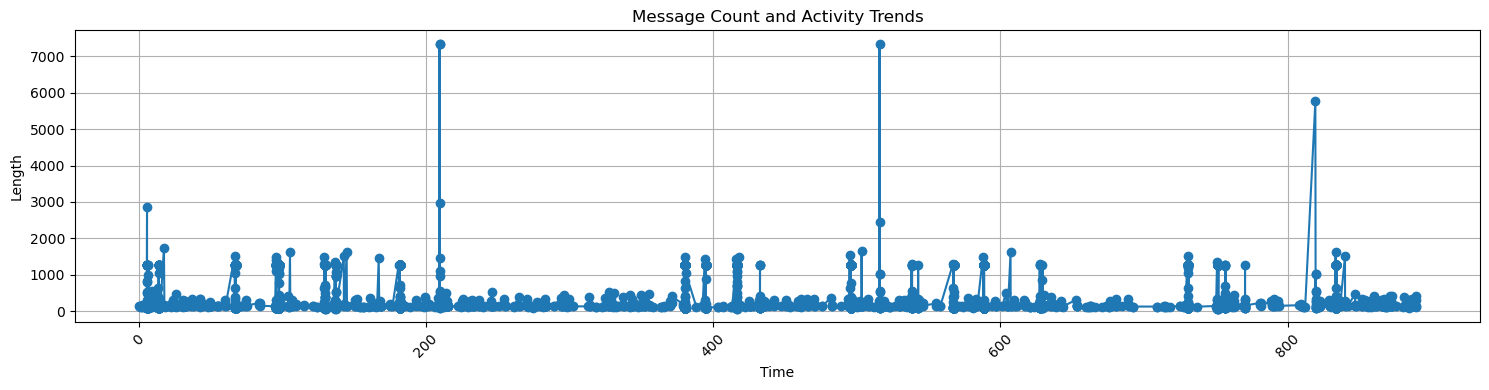

In [16]:
invalid = True
while invalid:
    answer = input("Please select which Whatsapp Group you want to analyze:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos and files\n"
                           "5 - Exit\n")
    if answer != '1' and answer != '2' and answer != '3' and answer != '4' and answer != '5':
        print("Invalid value. Please enter a valid number\n")
    elif answer == '5':
        invalid = False
        print("Goodbye")
    else:
        invalid = False
        df = load_csv(answer)
        plot_activity_trends(df)

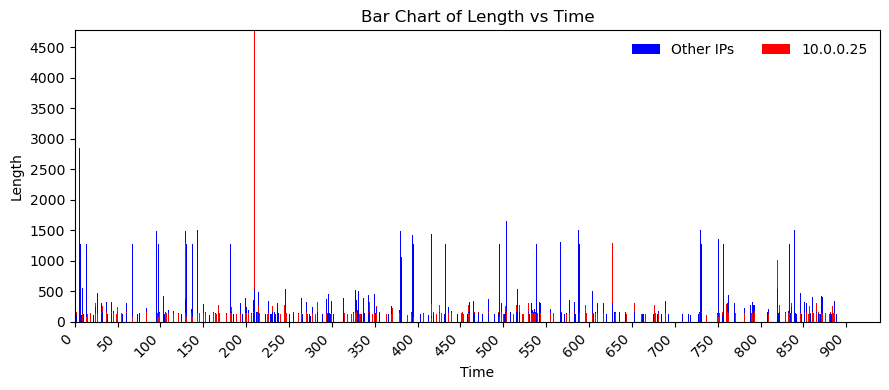

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
1350,1696.0,209.480931,10.0.2.15,157.240.214.60,TCP,7354.0,"59460 > 443 [PSH, ACK] Seq=14715 Ack=35528 W...",0.051279,7223.0
1351,1697.0,209.481081,10.0.2.15,157.240.214.60,TCP,7354.0,"59460 > 443 [PSH, ACK] Seq=22015 Ack=35528 W...",0.000150,0.0
2839,3817.0,515.816246,10.0.2.15,157.240.214.60,TCP,7354.0,"59460 > 443 [PSH, ACK] Seq=52357 Ack=69826 W...",0.109438,7189.0
4144,5551.0,819.259147,10.0.2.15,157.240.214.60,TLSv1.2,5770.0,Application Data,7.090506,5646.0


In [17]:
threshold = colored_bar_plot(df)
df[df["Length"]>threshold]

In [18]:
length_range_counts = count_length_ranges(df)
print("Count the amount of packets's length in each range")
for range_name, count in length_range_counts.items():
    print(f"range: {range_name} - {count}")

Count the amount of packets's length in each range
range: 0-50 - 0
range: 51-100 - 1486
range: 100-500 - 1169
range: 501-1000 - 50
range: 1001-1500 - 1745
range: >1500 - 18


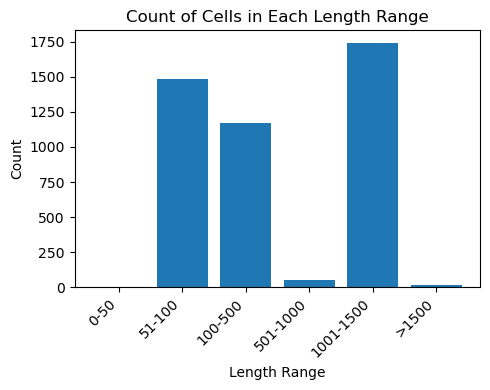

In [19]:
plot_length_range_counts(length_range_counts)

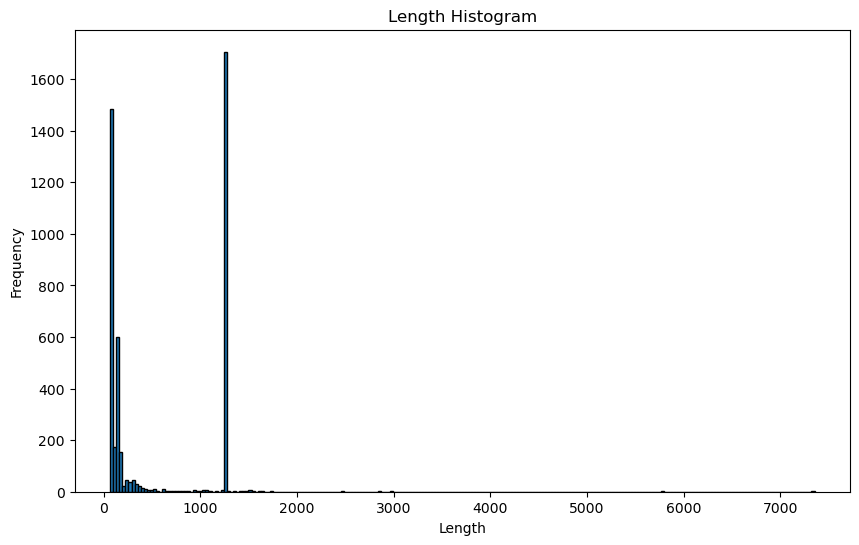

1350
7354.0


In [20]:
plot_length_histogram(df)
print (np.argmax(df["Length"]))
print (np.max(df["Length"]))

In [21]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,157.240.214.60,10.0.2.15,TLSv1.2,134.0,Application Data,0.000000,0.0
1,3.0,1.047416,10.0.2.15,157.240.214.60,TLSv1.2,122.0,Application Data,1.047416,12.0
2,5.0,2.096667,10.0.2.15,157.240.214.60,TLSv1.2,122.0,Application Data,1.049251,0.0
3,7.0,2.120104,10.0.2.15,157.240.214.60,TLSv1.2,160.0,Application Data,0.023437,38.0
4,9.0,2.282132,157.240.214.60,10.0.2.15,TLSv1.2,112.0,Application Data,0.162029,48.0
...,...,...,...,...,...,...,...,...,...
4463,6038.0,888.437245,157.240.214.60,10.0.2.15,TLSv1.2,131.0,Application Data,1.938162,19.0
4464,6040.0,889.249407,157.240.214.60,10.0.2.15,TLSv1.2,294.0,Application Data,0.812162,163.0
4465,6048.0,889.406154,10.0.2.15,157.240.214.60,QUIC,116.0,"0-RTT, DCID=e74a2660466dc358",0.156747,178.0
4466,6049.0,889.406659,10.0.2.15,157.240.214.60,QUIC,417.0,"0-RTT, DCID=e74a2660466dc358",0.000505,301.0


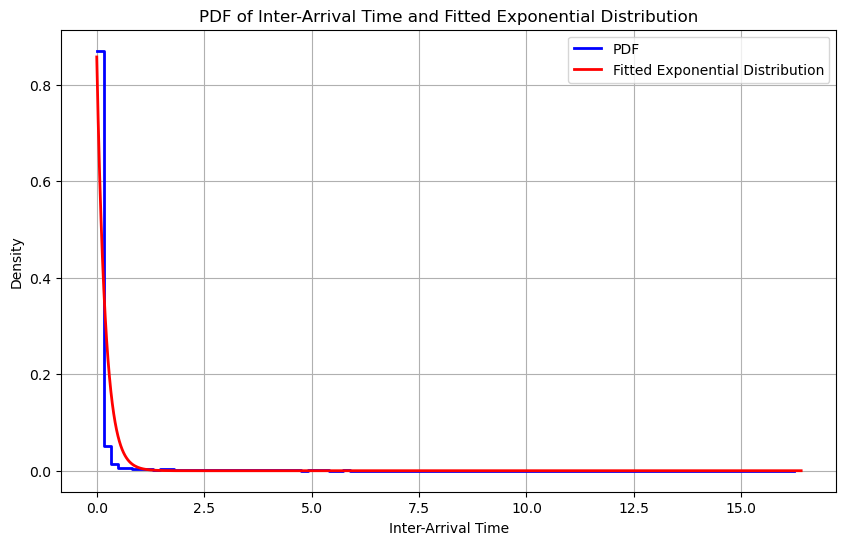

In [22]:
bin_edges, pdf = generate_pdf(df, bins=100)
plot_pdf_with_fitted_exponential(df, bin_edges, pdf)

In [23]:
df1, df2, df3, df4 = load_all()

dfs = [df1, df2, df3, df4]
labels = ['Mixed group (mostly messages)', 'Images group', 'Audio group', 'Video and Files group']
plot_ccdf(dfs, labels)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ohad1\\OneDrive\\שולחן העבודה\\לימודים\\שנה ב\\שנה ב סמסטר ב\\רשתות תקשורת\\מטלות\\מטלת גמר\\resources\\CLEAN/whatsappVideosCSVClean.csv'

In [ ]:
df[df["Time_delay"]>15]

In [ ]:
import matplotlib.pyplot as plt

def plot_time_delay_distribution(df):
    plt.figure(figsize=(10, 6))
    
    plt.hist(df['Time_delay'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Time Delay')
    plt.ylabel('Frequency')
    plt.title('Distribution of Time Delay')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

plot_time_delay_distribution(df)
df['Time_delay'].describe()

In [ ]:
import matplotlib.pyplot as plt

def plot_time_delay_over_time(df):
    plt.figure(figsize=(10, 6))
    
    plt.bar(df['Time'], df['Time_delay'], color='b')
    
    plt.xlabel('Time')
    plt.ylabel('Time Delay')
    plt.title('Time Delay over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_time_delay_over_time(df)
